# Create a mock DESI spectrum using a CoLoRe skewer

### This will require you to install desihub modules and igmhub/LyaMockP1D

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
# We will simulate only one quasar
Nq=1

### Get skewers from CoLoRe

In [4]:
# open data file (test file with few quasars)
hdulist = fits.open('../example_data/raw_colore/test_N1000.fits')
# get information about quasars (TYPE,RA,DEC,Z_COSMO,DZ_RSD)
catalog = hdulist[1].data
z_qso = catalog['Z_COSMO']
if len(z_qso) < Nq: 
    print('we need at least %d skewers ' % Nq)
    raise CoLoReError
print('will read %d skewers from CoLoRe outputs' % len(z_qso))

will read 1000 skewers from CoLoRe outputs


In [5]:
# get arraw with redshift in each cell of grid
z = hdulist[4].data['Z']
# get deltas (fluctuation around mean density) and line of sight velocity (actually, dz)
deltas = hdulist[2].data
velocities = hdulist[3].data
print(deltas.shape)

(1000, 2048)


### Generate quasar continua from desisim

We need help here! 
We would like qso.make_templates() to take the redshifts from the quasars in CoLoRe,
and then assign a random magnitude (following a QLF). Not sure how to do it...

In [6]:
from desisim import templates as dst
qso = dst.QSO()
continuum_flux, continuum_wave, metadata = qso.make_templates(nmodel=Nq,seed=123,lyaforest=False)
mock_zq = metadata['REDSHIFT'].data[0]
print('mock zq =',mock_zq)

mock zq = 2.99534362183


(3550, 6000)

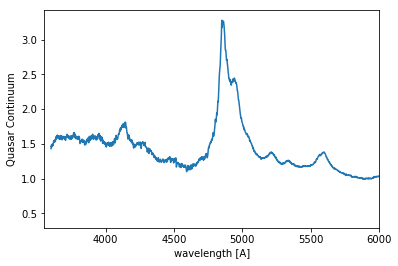

In [7]:
plt.plot(continuum_wave,continuum_flux[0])
plt.xlabel('wavelength [A]')
plt.ylabel('Quasar Continuum')
plt.xlim(3550,6000)

### Transform CoLoRe skewer to flux

In [8]:
# we will use the skewer from the highest-z quasar, so that we can make sure we cover all forest
id = np.argmax(z_qso)
delta = deltas[id]
density = 1+delta

In [9]:
import lya_mock_functions as mock
tau = mock.get_tau(z,density)
flux = np.exp(-tau)

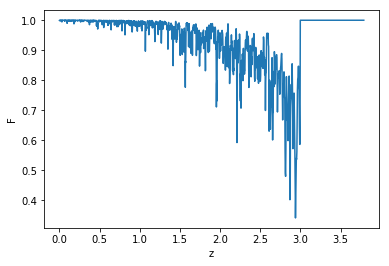

In [10]:
# only add absorption in the forest 
no_forest = (z > mock_zq)
flux[no_forest]=1.0
# plot flux vs redshift
plt.xlabel('z')
plt.ylabel('F')
plt.plot(z,flux)

### Combine quasar continuum with flux skewer

In [11]:
# will need to interpolate to pixels in quasar continuum
from scipy import interpolate
flux_interp = interpolate.interp1d(1215.67*(1+z),flux)
# will multiply this to quasar continuum
F = np.ones_like(continuum_wave)
in_skewer=(continuum_wave < 1215.67*(1+mock_zq))
F[in_skewer] = flux_interp(continuum_wave[in_skewer])

(3550, 6500)

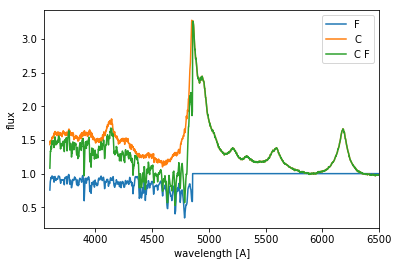

In [12]:
# plot flux vs redshift
plt.xlabel('wavelength [A]')
plt.ylabel('flux')
plt.plot(continuum_wave,F,label='F')
plt.plot(continuum_wave,continuum_flux[0],label='C')
plt.plot(continuum_wave,F*continuum_flux[0],label='C F')
plt.legend()
plt.xlim(3550,6500)